# CESM2-LE Initial Condition Memory:  MOC(sigma2)
 - Retrieve annual MOC from POP monthly output for all members from 1850-2100
 - Plot Hovmuller of micro-to-total variance vs. time
 - Request at least 50GB on Casper login to run this notebook

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
from os.path import exists
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import calc
import intake
import pop_tools
from datetime import timedelta
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2022.12.1'

## Start Dask Cluster

In [35]:
# Close out Dask Cluster and release workers:
cluster.close()
client.close()


Traceback (most recent call last):
  File "/glade/work/yeager/conda-envs/cesm2-LE/lib/python3.8/site-packages/distributed/utils.py", line 742, in wrapper
    return await func(*args, **kwargs)
  File "/glade/work/yeager/conda-envs/cesm2-LE/lib/python3.8/site-packages/distributed/client.py", line 1301, in _reconnect
    await self._ensure_connected(timeout=timeout)
  File "/glade/work/yeager/conda-envs/cesm2-LE/lib/python3.8/site-packages/distributed/client.py", line 1331, in _ensure_connected
    comm = await connect(
  File "/glade/work/yeager/conda-envs/cesm2-LE/lib/python3.8/site-packages/distributed/comm/core.py", line 315, in connect
    await asyncio.sleep(backoff)
  File "/glade/work/yeager/conda-envs/cesm2-LE/lib/python3.8/asyncio/tasks.py", line 648, in sleep
    return await future
asyncio.exceptions.CancelledError

Traceback (most recent call last):
  File "/glade/work/yeager/conda-envs/cesm2-LE/lib/python3.8/site-packages/distributed/utils.py", line 742, in wrapper
    ret

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        account='NCGD0011',
        walltime='02:00:00',
        local_directory='/glade/scratch/yeager/',
        log_directory='/glade/scratch/yeager/',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        "distributed.scheduler.worker-saturation": "1.0",
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

In [6]:
client

<Client: 'tcp://10.12.205.20:43054' processes=0 threads=0, memory=0 B>

# Section 1: Data Ingest

### Retrieve pre-computed MOC(sigma2) for CESM2-LE

In [7]:
ledir = '/glade/work/yeager/cesm_output/CESM2_LE/MOCsig2/'
f1 = ledir+'CESM2LE.MOCsig2.1???-1???.cmip6.nc'
f2 = ledir+'CESM2LE.MOCsig2.2000-????.cmip6.nc'
f3 = ledir+'CESM2LE.MOCsig2.2010-????.cmip6.nc'
f4 = ledir+'CESM2LE.MOCsig2.20[1-9]5-????.cmip6.nc'
ds1 = xr.open_mfdataset(f1,combine='by_coords',
                       #preprocess=preprocessor,
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,chunks={'member_id':1})
ds2 = xr.open_mfdataset(f2,combine='by_coords',
                       #preprocess=preprocessor,
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,chunks={'member_id':1})
ds3 = xr.open_mfdataset(f3,combine='by_coords',
                       #preprocess=preprocessor,
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,chunks={'member_id':1})
ds4 = xr.open_mfdataset(f4,combine='by_coords',
                       #preprocess=preprocessor,
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,chunks={'member_id':1})
ds_cmip6 = xr.concat([ds1,ds2,ds3,ds4],dim='time')
cmip6_mocsig = ds_cmip6.MOC.sum('moc_comp').chunk({'time':251})

In [8]:
ledir = '/glade/work/yeager/cesm_output/CESM2_LE/MOCsig2/'
f1 = ledir+'CESM2LE.MOCsig2.1???-1???.smbb.nc'
f2 = ledir+'CESM2LE.MOCsig2.2000-????.smbb.nc'
f3 = ledir+'CESM2LE.MOCsig2.2010-????.smbb.nc'
f4 = ledir+'CESM2LE.MOCsig2.20[1-9]5-????.smbb.nc'
ds1 = xr.open_mfdataset(f1,combine='by_coords',
                       #preprocess=preprocessor,
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,chunks={'member_id':1})
ds2 = xr.open_mfdataset(f2,combine='by_coords',
                       #preprocess=preprocessor,
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,chunks={'member_id':1})
ds3 = xr.open_mfdataset(f3,combine='by_coords',
                       #preprocess=preprocessor,
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,chunks={'member_id':1})
#ds3 = ds3.assign_coords({'member_id':ds2.member_id})
ds4 = xr.open_mfdataset(f4,combine='by_coords',
                       #preprocess=preprocessor,
                       coords="minimal",compat="override",data_vars="minimal",
                       parallel=True,chunks={'member_id':1})
ds_smbb = xr.concat([ds1,ds2,ds3,ds4],dim='time')
smbb_mocsig = ds_smbb.MOC.sum('moc_comp').chunk({'time':251})

In [9]:
mocsig = xr.concat([cmip6_mocsig,smbb_mocsig],dim='member_id').astype('float32')
mocsig

<xarray.DataArray 'MOC' (member_id: 100, time: 251, transport_reg: 2,
                         sigma: 86, lat_aux_grid: 395)>
dask.array<concatenate, shape=(100, 251, 2, 86, 395), dtype=float32, chunksize=(1, 251, 2, 86, 395), chunktype=numpy.ndarray>
Coordinates:
  * lat_aux_grid   (lat_aux_grid) float64 -79.49 -78.95 -78.42 ... 89.47 90.0
  * member_id      (member_id) object 'r10i1181p1f1' ... 'r9i1171p1f2'
  * sigma          (sigma) float32 0.0 28.1 28.3 28.5 ... 37.88 37.93 37.97
  * transport_reg  (transport_reg) |S256 b'Global Ocean - Marginal Seas' b'At...
  * time           (time) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100

In [10]:
np.unique(mocsig.member_id.data).size

100

In [11]:
## Convert to dataset
memid = mocsig.member_id.data
inityear = xr.DataArray([i.split('i')[1].split('p')[0] for i in memid],coords={'member_id':mocsig.member_id})
memnum = xr.DataArray([i.split('i')[0].split('r')[1].rjust(3,'0') for i in memid],coords={'member_id':mocsig.member_id})

ds = mocsig.to_dataset()
ds['inityear'] = inityear
ds['memnum'] = memnum

In [12]:
%%time
ds = ds.load()

CPU times: user 20 s, sys: 10.1 s, total: 30.1 s
Wall time: 1min 13s


In [9]:
#%%time
#from dask.distributed import wait
#ds = ds.persist()
#daskout = wait(ds)

# Section 2: ICM Analysis

In [13]:
# Print summary of initialization years in dataset
iyear = ds.inityear.data
print("Start Year : Members")
for i in set(iyear):
    count = np.count_nonzero(iyear==i)
    print(i+" : "+str(count).zfill(3))

Start Year : Members
1191 : 001
1071 : 001
1011 : 001
1051 : 001
1101 : 001
1171 : 001
1161 : 001
1091 : 001
1001 : 001
1251 : 020
1281 : 020
1031 : 001
1141 : 001
1231 : 020
1151 : 001
1041 : 001
1301 : 020
1021 : 001
1121 : 001
1131 : 001
1081 : 001
1181 : 001
1061 : 001
1111 : 001


## Remove PI-Control Drift

In [14]:
%%time
pidir = '/glade/work/yeager/cesm_output/CESM2_picntrl/'
f0 = pidir+'b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.0001-2000.MOCsig.nc'
ds0 = xr.open_dataset(f0)
#ds0 = xr.open_dataset(f0),chunks={'time':120}).persist()
#daskresult = wait(ds0)

CPU times: user 24.4 ms, sys: 10.2 ms, total: 34.6 ms
Wall time: 109 ms


In [15]:
pi_mocsig = ds0.MOC.sum('moc_comp')
pi_mocsig

<xarray.DataArray 'MOC' (time: 2000, transport_reg: 2, sigma: 86,
                         lat_aux_grid: 395)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           1.69840496e-05,  5.96646350e-06,  1.77070069e-06],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           1.70855837e-05,  6.06800359e-06,  1.87223645e-06],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           1.69095711e-05,  5.89198544e-06,  1.69621876e-06],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -1.99223287e-08, -1.99223287e-08, -1.99223287e-08],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           8.21090396e-09,  8.21090396e-09,  8.21090396e-09],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           3.94515887e-09,  3.94515887e-09,  3.94515887e-09]],

        [[ 1.00118148e+00,  1.00118148e+00,  1.00118148e+00, ...,
           1.02315676e+00,  1.02314579e+00,  1.02314162e+00],
         [ 1.00118148e+00,  1.00118148e+00,  1.00118148e+00, ...,
           1.02315688e+00,  1.02314579e+00,  1.02314174e+00],
         [ 1.00118148e+00,  1.00118148e+00,  1.00118148e+00, ...,
           1.02315676e+00,  1.02314591e+00,  1.02314162e+00],
...
          -2.04305515e-08, -2.04305515e-08, -2.04305515e-08],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -3.18136095e-08, -3.18136095e-08, -3.18136095e-08],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -6.05510486e-09, -6.05510486e-09, -6.05510486e-09]],

        [[ 8.69136512e-01,  8.69136512e-01,  8.69136512e-01, ...,
           8.39495420e-01,  8.39441180e-01,  8.39420199e-01],
         [ 8.69136512e-01,  8.69136512e-01,  8.69136512e-01, ...,
           8.39495420e-01,  8.39441180e-01,  8.39420259e-01],
         [ 8.69136512e-01,  8.69136512e-01,  8.69136512e-01, ...,
           8.39495361e-01,  8.39441180e-01,  8.39420199e-01],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -1.52832520e-08, -1.52832520e-08, -1.52832520e-08],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -2.66561386e-08, -2.66561386e-08, -2.66561386e-08],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -6.04493167e-09, -6.04493167e-09, -6.04493167e-09]]]],
      dtype=float32)
Coordinates:
  * lat_aux_grid   (lat_aux_grid) float64 -79.49 -78.95 -78.42 ... 89.47 90.0
  * sigma          (sigma) float32 0.0 28.1 28.3 28.5 ... 37.88 37.93 37.97
  * transport_reg  (transport_reg) |S256 b'Global Ocean - Marginal Seas' b'At...
  * time           (time) int64 1 2 3 4 5 6 7 ... 1995 1996 1997 1998 1999 2000

In [17]:
def fit_poly(dat, dim, degree):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    #dat = dat-fit
    return fit

In [18]:
pi_trend = fit_poly(pi_mocsig.sel(time=slice(800,1600)),'time',1)

#### Compute MOCsig anomalies as deviation from long term PI-Control trend (0800-1600)

In [19]:
# Loop over member_id, subtracting appropriate time slice of pi_trend from full MOCsig:
member_id = ds.member_id
memlist = []
for mem in member_id.values:
    ds_tmp = ds.sel(member_id=mem)
    y0 = int(ds_tmp.inityear.data.tolist())
    y1 = y0+250
    trend = pi_trend.sel(time=slice(y0,y1))
    trend['time'] = trend['time'] + (1850-y0)
    ds_tmp['MOC'] = ds_tmp['MOC'] - trend
    memlist.append(ds_tmp)
ds_anom = xr.concat(memlist,dim=member_id).astype('float32')

In [20]:
ds_anom.MOC

<xarray.DataArray 'MOC' (member_id: 100, time: 251, transport_reg: 2,
                         sigma: 86, lat_aux_grid: 395)>
array([[[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            9.93896089e-03,  9.97205544e-03,  9.98397358e-03],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            9.93927475e-03,  9.97237023e-03,  9.98429023e-03],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            9.93912388e-03,  9.97221842e-03,  9.98413842e-03],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           -4.22962465e-08, -4.22962465e-08, -4.22962465e-08],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           -6.35231032e-08, -6.35231032e-08, -6.35231032e-08],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           -4.11467944e-08, -4.11467944e-08, -4.11467944e-08]],

         [[-4.50892597e-02, -4.50892597e-02, -4.50892597e-02, ...,
           -2.74229292e-02, -2.73899827e-02, -2.73779966e-02],
          [-4.50892597e-02, -4.50892597e-02, -4.50892597e-02, ...,
           -2.74229310e-02, -2.73899827e-02, -2.73778792e-02],
          [-4.50892597e-02, -4.50892597e-02, -4.50892597e-02, ...,
           -2.74230503e-02, -2.73899827e-02, -2.73779966e-02],
...
           -2.11521893e-08, -2.11521893e-08, -2.11521893e-08],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           -1.34141294e-08, -1.34141294e-08, -1.34141294e-08],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           -3.56659093e-08, -3.56659093e-08, -3.56659093e-08]],

         [[-1.70938373e-01, -1.70938373e-01, -1.70938373e-01, ...,
           -1.92252859e-01, -1.92247793e-01, -1.92250252e-01],
          [-1.70938373e-01, -1.70938373e-01, -1.70938373e-01, ...,
           -1.92252800e-01, -1.92247793e-01, -1.92250267e-01],
          [-1.70938373e-01, -1.70938373e-01, -1.70938373e-01, ...,
           -1.92252800e-01, -1.92247733e-01, -1.92250267e-01],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           -2.13424176e-08, -2.13424176e-08, -2.13424176e-08],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           -1.62656875e-08, -1.62656875e-08, -1.62656875e-08],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           -3.29913625e-08, -3.29913625e-08, -3.29913625e-08]]]]],
      dtype=float32)
Coordinates:
  * lat_aux_grid   (lat_aux_grid) float64 -79.49 -78.95 -78.42 ... 89.47 90.0
  * member_id      (member_id) object 'r10i1181p1f1' ... 'r9i1171p1f2'
  * sigma          (sigma) float32 0.0 28.1 28.3 28.5 ... 37.88 37.93 37.97
  * transport_reg  (transport_reg) |S256 b'Global Ocean - Marginal Seas' b'At...
  * time           (time) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100

In [17]:
%%time
from dask.distributed import wait
ds = ds.persist()
daskout = wait(ds)

CPU times: user 15.1 s, sys: 444 ms, total: 15.5 s
Wall time: 39.4 s


In [18]:
%%time
ds_anom = ds_anom.persist()
daskout = wait(ds_anom)

CPU times: user 22.6 ms, sys: 940 µs, total: 23.5 ms
Wall time: 25.5 ms


## Apply Low-Pass Filter

In [21]:
def lpf_anndata(dat, period=10):
    fs=1/(365*24*3600)        # 1 year in Hz (sampling frequency)
    nyquist = fs / 2          # 0.5 times the sampling frequency
    cutoff = fs/period            # cutoff frequency
    cutoff = cutoff/nyquist   # as fraction of nyquist  
    print('cutoff= ',(1/(cutoff*nyquist))/(365*24*3600),' years') 
    filtsos = signal.butter(4, cutoff, 'lowpass', output='sos') #low pass filter
    filtb, filta = signal.butter(4, cutoff, 'lowpass')
    dat_out = xr.apply_ufunc(signal.sosfiltfilt, 
                             filtsos,dat.fillna(0),
                             dask='allowed',
                             kwargs={'padtype':'even','axis':0}).where(dat.notnull()).astype('float32')
    return dat_out

In [22]:
%%time
moc_lpf = lpf_anndata(ds.MOC.transpose('time','transport_reg','member_id','sigma','lat_aux_grid'),period=15)

cutoff=  15.000000000000002  years
CPU times: user 57.4 s, sys: 15 s, total: 1min 12s
Wall time: 1min 17s


In [23]:
%%time
moc_anom_lpf = lpf_anndata(ds_anom.MOC.transpose('time','transport_reg','member_id','sigma','lat_aux_grid'),period=15)

cutoff=  15.000000000000002  years
CPU times: user 57.4 s, sys: 15.2 s, total: 1min 12s
Wall time: 1min 17s


In [24]:
#%%time
#moc_anom_lpf = moc_anom_lpf.persist()
#daskout = wait(moc_anom_lpf)

## Guide to Micro and Macro Ensembles:
  - 20-member micro ensembles referred to by start year: 1231, 1251, 1281, 1301
  - 10-member "macro1a" ensemble, initialized: 1001, 1021, 1041, 1061, 1081, 1101, 1121, 1141, 1161, 1181
  - 10-member "macro1b" (MOAR) ensemble, initialized: 1011, 1031, 1051, 1071, 1091, 1111, 1131, 1151, 1171, 1191
  - 10-member "macro2" ensemble (CMIP6 contribution):  b.e21.BHIST.f09_g17.CMIP6-historical.{001-010}


## Decomposition of Ensemble Variance:

Following Singh et al. (2021, in review), decompose CESM2LE ensemble variance for variable X as follows: 
$$ 
\sigma^{2}_{X} = \sigma^{2}_{X,ocn} + \sigma^{2}_{X,atm} 
$$ 
where "ocn" quantifies spread between micro ensembles (due to different ocean initial conditions), and "atm" quantifies spread within micro ensembles (due to perturbed atmospheric initial conditions). Variance within micro ensembles is computed as the average ensemble variance (with p=4, m=20):
$$ 
\sigma^{2}_{X,atm} = \frac{1}{p}\sum_{k=1}^{p}\frac{\sum_{j=1}^{m}(X_{k,j}-\overline{X_{k}})^2}{m}
$$ 
Variance across micro ensembles is computed as:
$$ 
\sigma^{2}_{X,ocn} = \frac{\sum_{k=1}^{p}(\overline{X_{k}}-\overline{X})^2}{p}
$$ 
where $\overline{X}$ is the mean over the full (80 member) ensemble. The fraction of ensemble variance attributable to ocean initial conditions is then:
$$ 
\chi_{ocn}(t) = \frac{\sigma^{2}_{X,ocn}(t)}{\sigma^{2}_{X}(t)}
$$ 

For denominator, keep only the 4 20-member micro ensemble members (80 members total):

In [25]:
iyear = ds.inityear.data
memind = np.nonzero((iyear=='1231') | (iyear=='1251') | (iyear=='1281') | (iyear=='1301'))
da_allmem = moc_lpf.isel(member_id=memind[0])
sig2_tot = da_allmem.var(dim='member_id')
allmean = da_allmem.mean(dim='member_id').load()

In [26]:
# Compute Ensemble Variance Decomposition:
plist = ['1231','1251','1281','1301']
varlist = []
meanlist = []
iyear = ds.inityear.data
for p in plist:
    memind = np.nonzero(iyear==p)
    da_oneinit = moc_anom_lpf.isel(member_id=memind[0])
    var = da_oneinit.var('member_id')
    mean = da_oneinit.mean('member_id')
    varlist.append(var)
    meanlist.append(mean)
sig2_atm = xr.concat(varlist,dim='p').mean('p')
sig2_ocn = xr.concat(meanlist,dim='p').var('p')
sig2_ocn_p = xr.concat(meanlist,dim=xr.DataArray(plist,dims='p',name='p'))
sig2_ocn_p = (sig2_ocn_p - sig2_tot)**2

# Compute Chi
chi_atm = (sig2_atm/sig2_tot).rename("Chi_atm")
chi_ocn = (sig2_ocn/sig2_tot).rename("Chi_ocn")
chi_ocn_p = (sig2_ocn_p/sig2_tot).rename("Chi_ocn")

## Compute bootstrapped significance

In [27]:
import xskillscore as xs

Resample 80-member pool (with replacement), to generate 100 different synthetic 20-member "micro" ensembles:

In [28]:
%%time
iterations = 100
ens_size = 20
da_allmem = moc_anom_lpf.isel(member_id=memind[0])
da_allmem_r = xs.resample_iterations_idx(da_allmem.chunk(), iterations, 'member_id', dim_max=ens_size).rename({'iteration':'micro'})

CPU times: user 1.67 s, sys: 272 ms, total: 1.94 s
Wall time: 2.03 s


Now, resample again to generate 500 different 4-micro combinations:

In [29]:
da_allmem_rr = xs.resample_iterations(da_allmem_r, 500, 'micro', dim_max=4)

Compute resampled distributions of sig2_atm, sig2_ocn, and chi_ocn:

In [30]:
%%time
sig2_atm_r = da_allmem_rr.var(dim='member_id').mean('micro')
sig2_ocn_r = da_allmem_rr.mean(dim='member_id').var('micro')
sig2_tot_r = da_allmem_rr.var(dim=['member_id','micro'])
chi_atm_r = (sig2_atm_r/sig2_tot_r).rename("Chi_atm_r").persist()
chi_ocn_r = (sig2_ocn_r/sig2_tot_r).rename("Chi_ocn_r").persist()

CPU times: user 3.56 s, sys: 318 ms, total: 3.87 s
Wall time: 4.05 s


In [31]:
%%time
pval_chi_ocn = (chi_ocn_r > chi_ocn).sum('iteration')/chi_ocn_r['iteration'].size
pval_chi_ocn = pval_chi_ocn.load()

KilledWorker: Attempted to run task ('select_bootstrap_indices_ufunc-select_bootstrap_indices_ufunc_0-transpose-c11617dfce52e02e85ea990047063891', 0, 0, 0, 0, 0, 0) on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://10.12.206.60:40516. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

### Plot Chi for MOCsig as a function of historical time

CPU times: user 5.54 s, sys: 189 ms, total: 5.73 s
Wall time: 6 s


<timed exec>:88: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


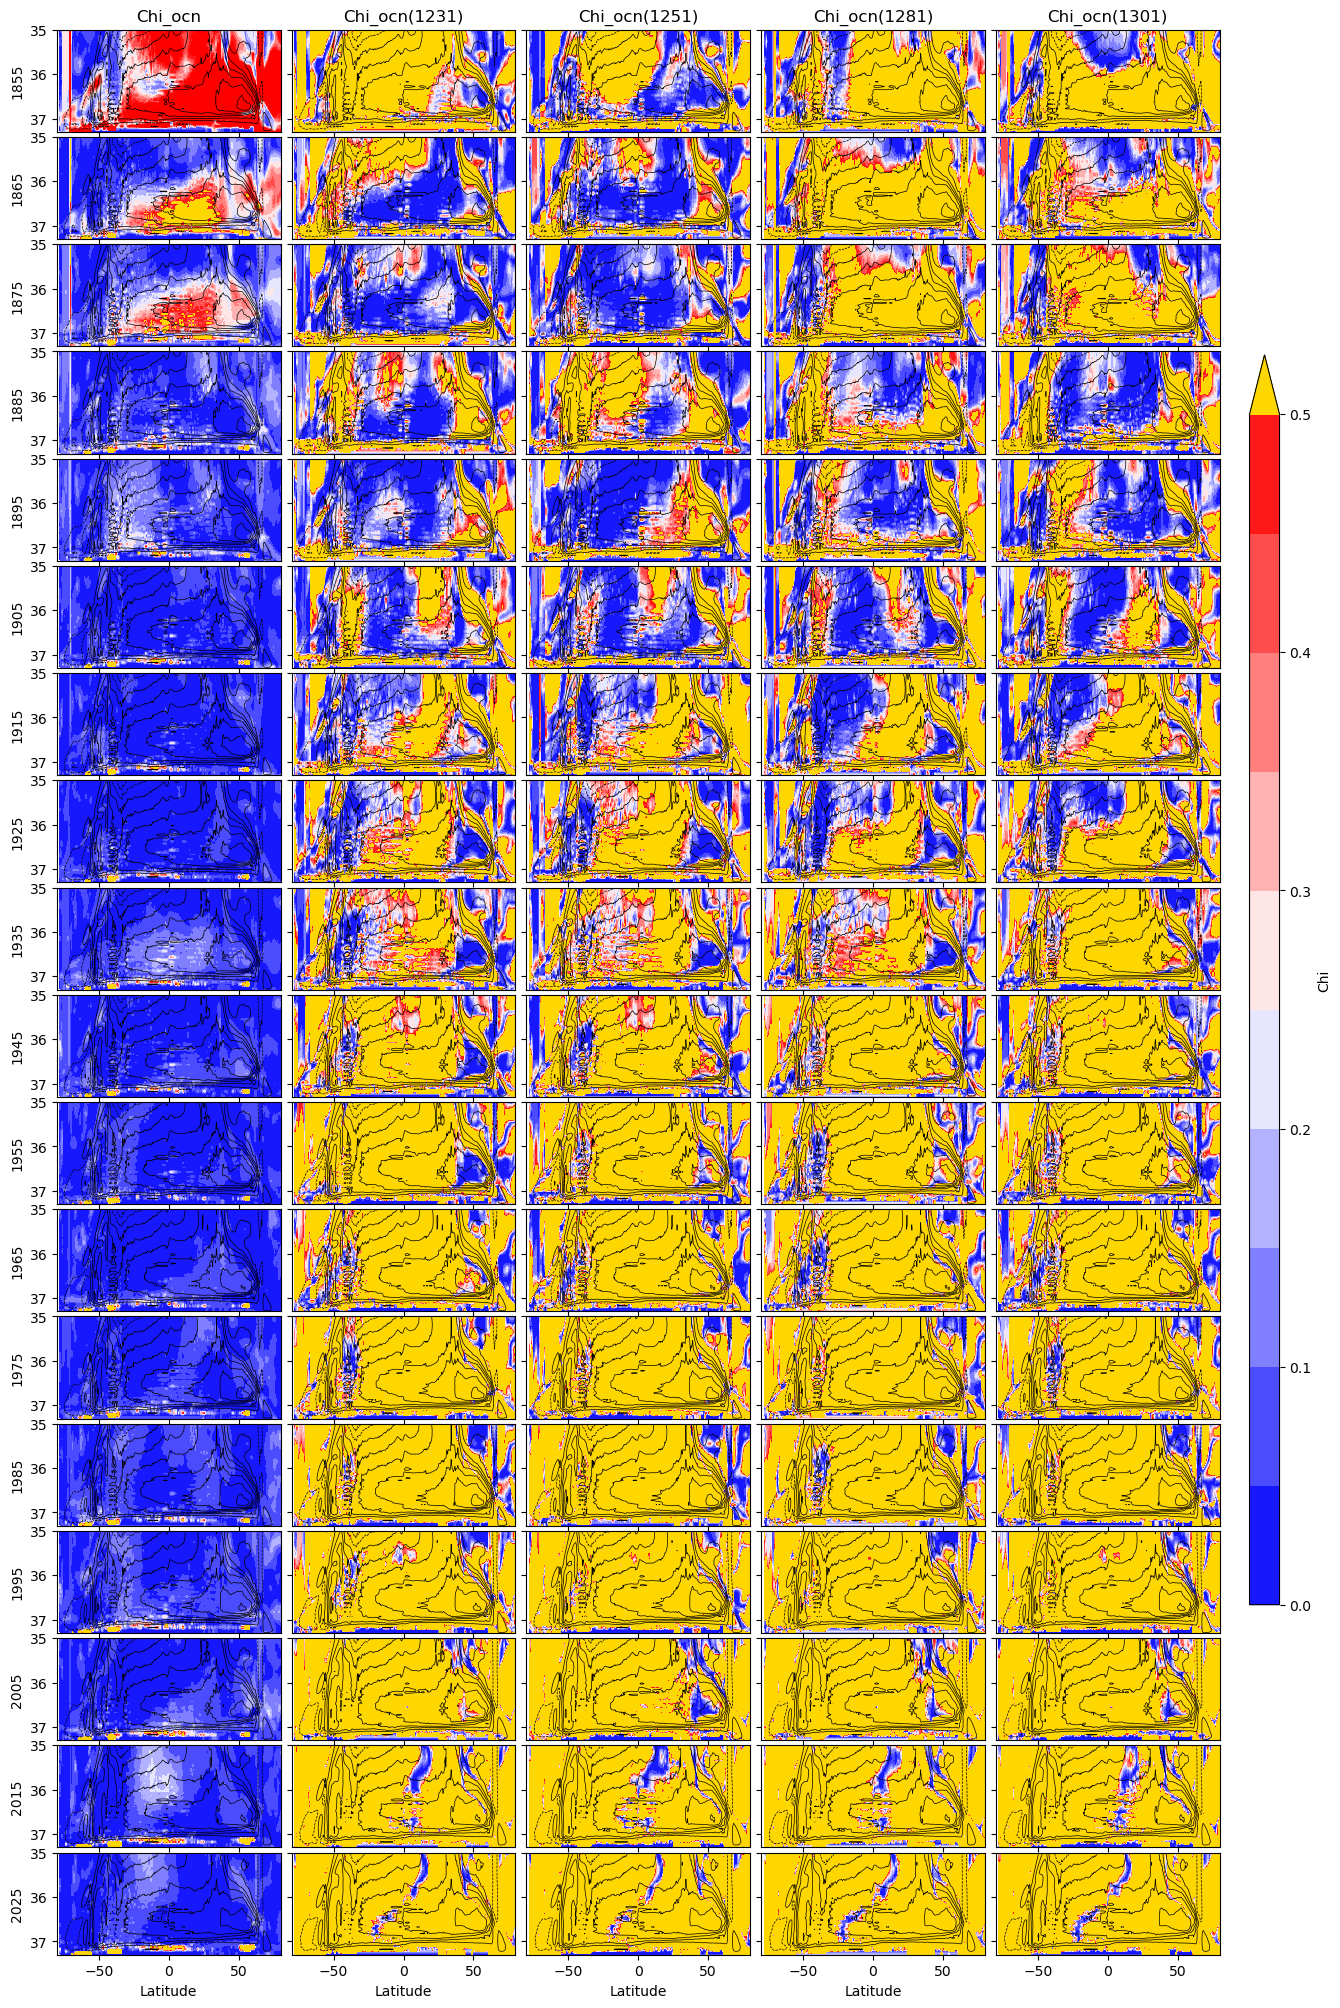

In [34]:
%%time
time0 = np.arange(1855,2035,10)
nrow = np.shape(time0)[0]
ncol = 5
fig = plt.figure(figsize=(15, 25))

#mnlevs = np.arange(0,31,1)*2. - 30.
mnlevs = np.arange(0,16,1)*4. - 30.
chilevs = np.arange(0,11,1)*0.05
yticks = [29,30,31,32,33,34,35,36,37,38]
colmap = copy.copy(plt.cm.bwr)
fontsize=12

xlim=[-80,80]
ylim=[37.3,35.]
imax = np.array(range(nrow)).max()

for i in range(nrow):
    y0 = time0[i]
    timestamp = str(y0)
    mean = allmean.sel(time=y0).isel(transport_reg=0)
    chi_o = chi_ocn.sel(time=y0).isel(transport_reg=0)
    chi_o_p = chi_ocn_p.sel(time=y0).isel(transport_reg=0)
    
    ax1 = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr1 = ax1.contour(mean.lat_aux_grid, mean.sigma, mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr1a = ax1.contourf(chi_o.lat_aux_grid, chi_o.sigma, chi_o,levels=chilevs, cmap=colmap, extend='max')
    cntr1a.cmap.set_under('cyan')
    cntr1a.cmap.set_over('gold')
    ax1.set_ylim(ylim)
    ax1.set_xlim(xlim)
    ax1.set_ylabel(timestamp)
    if i!=imax: ax1.set_xticklabels([])
    if i==0: ax1.set_title('Chi_ocn', fontdict={'size':fontsize}, loc='center')
        
    ax2 = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr2 = ax2.contour(mean.lat_aux_grid, mean.sigma, mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr2a = ax2.contourf(chi_o_p.lat_aux_grid, chi_o_p.sigma, chi_o_p.sel(p='1231'),levels=chilevs, cmap=colmap, extend='both')
    cntr2a.cmap.set_under('cyan')
    cntr2a.cmap.set_over('gold')
    ax2.set_ylim(ylim)
    ax2.set_xlim(xlim)
    if i!=imax: ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    if i==0: ax2.set_title('Chi_ocn(1231)', fontdict={'size':fontsize}, loc='center')
        
    ax3 = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr3 = ax3.contour(mean.lat_aux_grid, mean.sigma, mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr3a = ax3.contourf(chi_o_p.lat_aux_grid, chi_o_p.sigma, chi_o_p.sel(p='1251'),levels=chilevs, cmap=colmap, extend='both')
    cntr3a.cmap.set_under('cyan')
    cntr3a.cmap.set_over('gold')
    ax3.set_ylim(ylim)
    ax3.set_xlim(xlim)
    if i!=imax: ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    if i==0: ax3.set_title('Chi_ocn(1251)', fontdict={'size':fontsize}, loc='center')
    
    ax4 = fig.add_subplot(nrow,ncol,i*ncol+4)
    cntr4 = ax4.contour(mean.lat_aux_grid, mean.sigma, mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr4a = ax4.contourf(chi_o_p.lat_aux_grid, chi_o_p.sigma, chi_o_p.sel(p='1281'),levels=chilevs, cmap=colmap, extend='both')
    cntr4a.cmap.set_under('cyan')
    cntr4a.cmap.set_over('gold')
    ax4.set_ylim(ylim)
    ax4.set_xlim(xlim)
    if i!=imax: ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    if i==0: ax4.set_title('Chi_ocn(1281)', fontdict={'size':fontsize}, loc='center')
    
    ax5 = fig.add_subplot(nrow,ncol,i*ncol+5)
    cntr5 = ax5.contour(mean.lat_aux_grid, mean.sigma, mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr5a = ax5.contourf(chi_o_p.lat_aux_grid, chi_o_p.sigma, chi_o_p.sel(p='1301'),levels=chilevs, cmap=colmap, extend='both')
    cntr5a.cmap.set_under('cyan')
    cntr5a.cmap.set_over('gold')
    ax5.set_ylim(ylim)
    ax5.set_xlim(xlim)
    if i!=imax: ax5.set_xticklabels([])
    ax5.set_yticklabels([])
    if i==0: ax5.set_title('Chi_ocn(1301)', fontdict={'size':fontsize}, loc='center')
        
    if (i==np.array(range(nrow)).max()):
        ax1.set_xlabel('Latitude')
        ax2.set_xlabel('Latitude')
        ax3.set_xlabel('Latitude')
        ax4.set_xlabel('Latitude')

fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1a, cax=cbar_ax, label='Chi', extend='both')

In [31]:
chi_ocn.data[:,1,0:92] = np.nan

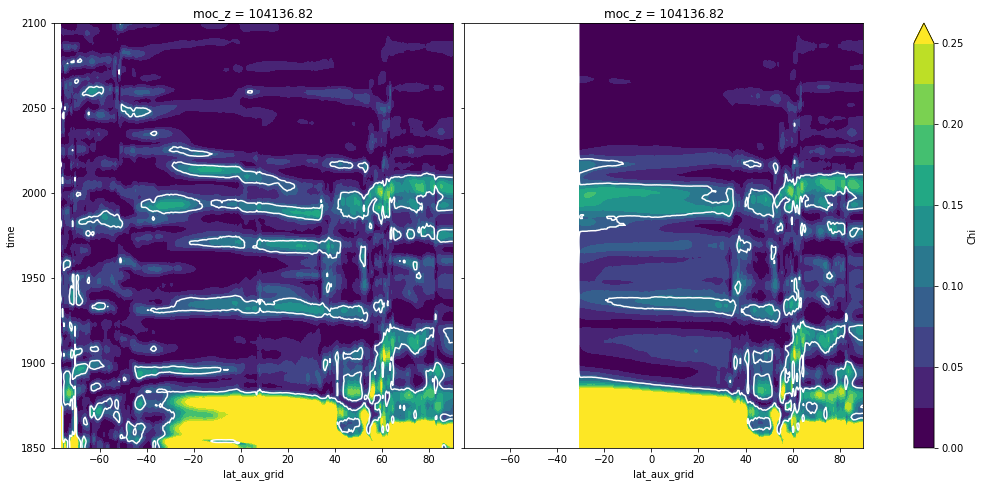

In [32]:
# Plot with bootstrapped significance
pval = (chi_ocn_r > chi_ocn).sum('iteration')/chi_ocn_r['iteration'].size
clevs = np.arange(0,11)*0.025

g = chi_ocn.plot.contourf(col='transport_reg',size=7,levels=clevs,cmap='viridis')
for i, ax in enumerate(g.axes.flat):
    pval.isel(transport_reg=i).plot.contour(ax=ax,levels=[0.05],colors=['white'])
    if (i>0): ax.set_ylabel('')

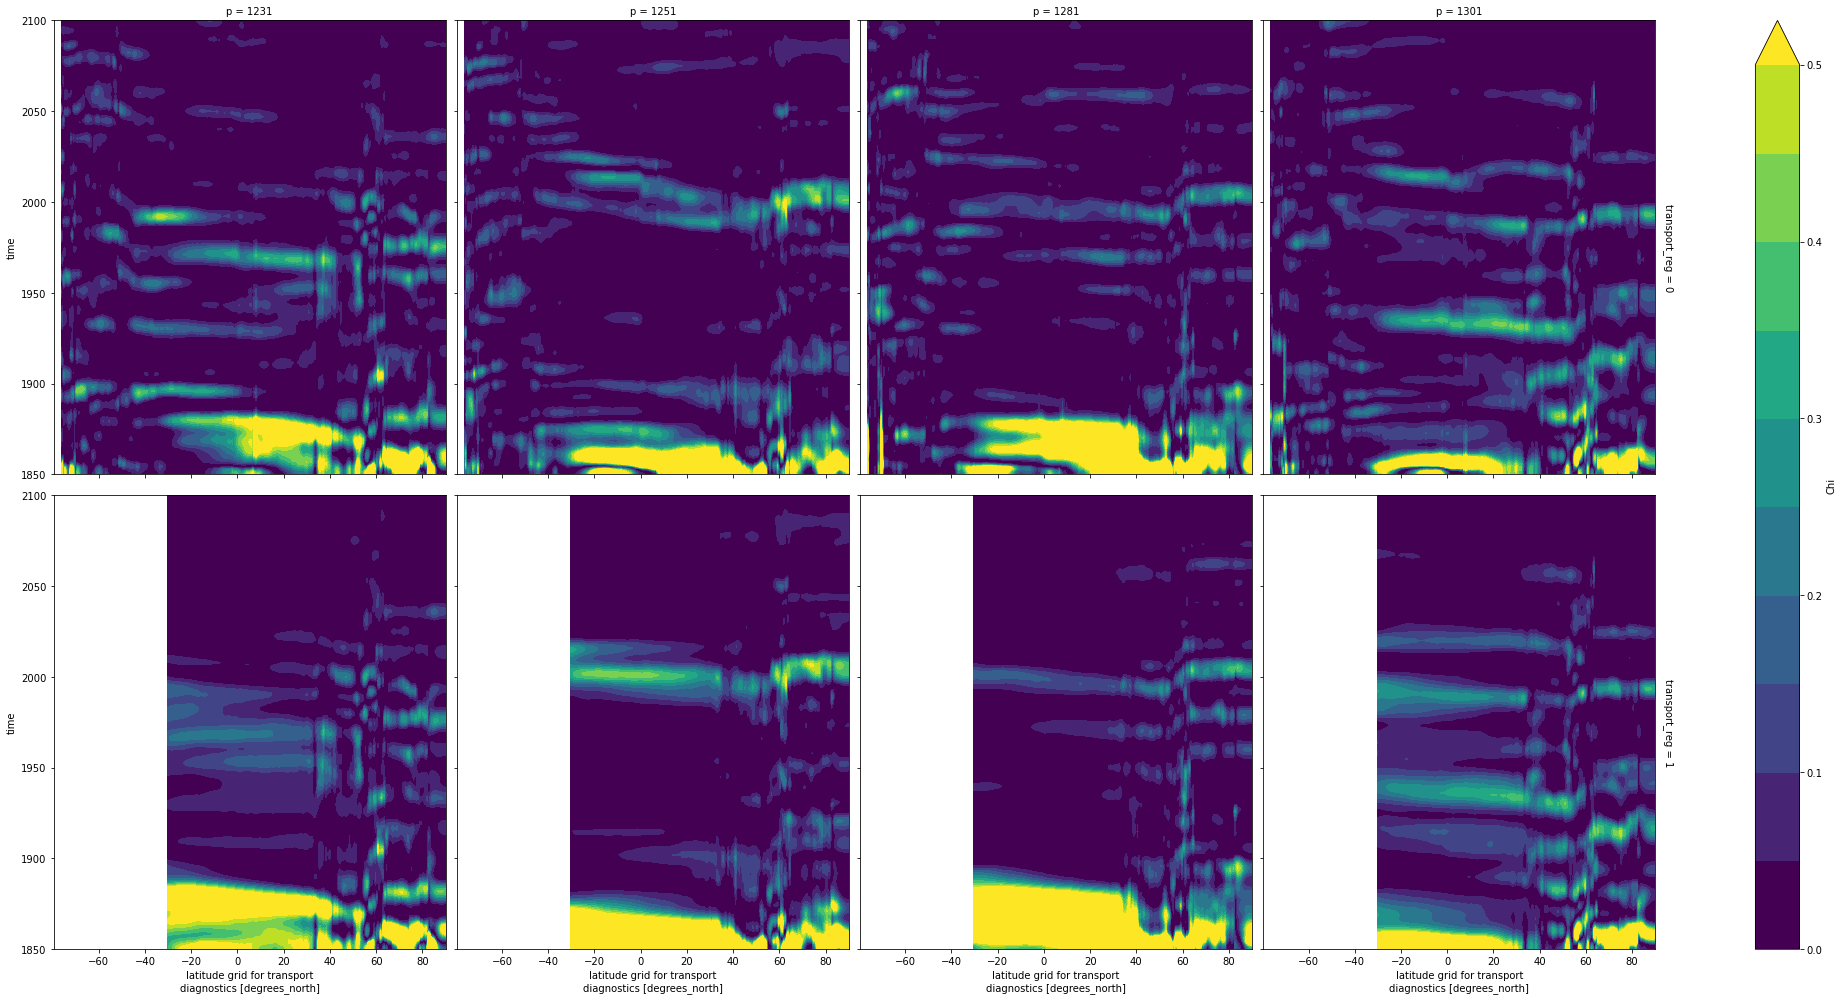

In [33]:
chi_ocn_p.data[:,:,1,0:92] = np.nan
# Plot decomposition of Chi_ocn by init year:
levs = np.arange(0,11)*0.05
chi_ocn_p.plot.contourf(col='p',row='transport_reg',size=7,levels=levs)

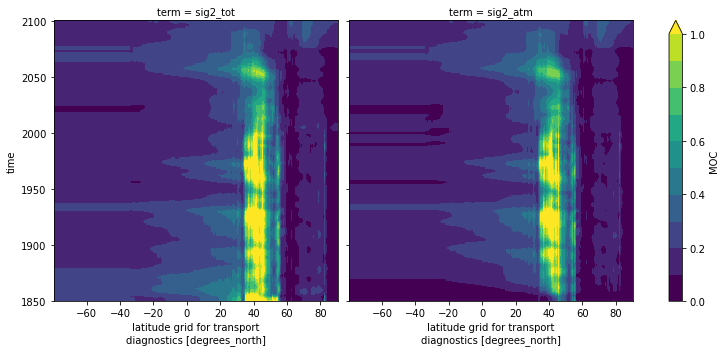

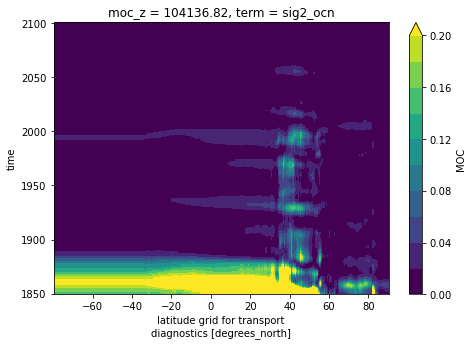

In [38]:
terms = xr.DataArray(['sig2_tot','sig2_atm','sig2_ocn','sig2_residual'],dims='term',name='term')
sig2_resid = sig2_tot - (sig2_atm+sig2_ocn)
sig2 = xr.concat([sig2_tot,sig2_atm,sig2_ocn,sig2_resid],dim=terms)

levs = np.arange(0,11)*0.1
sig2.isel(term=[0,1],transport_reg=1).plot(col='term',col_wrap=2,size=5,levels=levs)
levs = np.arange(0,11)*0.02
sig2.isel(term=2,transport_reg=1).plot(size=5,levels=levs)

## Explore Effect of Model Drift

In [16]:
def time_set_midmonth(ds, time_name):
    year = ds[time_name].dt.year
    month = ds[time_name].dt.month
    year = xr.where(month==1,year-1,year)
    month = xr.where(month==1,12,month-1)
    nmonths = len(month)
    newtime = [cftime.DatetimeNoLeap(year[i], month[i], 15) for i in range(nmonths)]
    ds[time_name] = newtime
    return ds

In [17]:
from dask.distributed import wait

In [18]:
%%time
pidir = '/glade/work/yeager/cesm_output/CESM2_picntrl/'
f0 = pidir+'b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.000101-200012.MOC.nc'
ds0 = time_set_midmonth(xr.open_dataset(f0,chunks={'time':120}),'time').persist()
daskresult = wait(ds0)

CPU times: user 6.64 s, sys: 333 ms, total: 6.97 s
Wall time: 15.6 s


In [19]:
moc30_pi = ds0.MOC.isel(transport_reg=1).sel(moc_z=100000.,lat_aux_grid=30.,method='nearest').sum('moc_comp')
moc30_pi_ann = moc30_pi.groupby('time.year').mean().rename({'year':'time'})

In [20]:
def fit_poly(dat, dim, degree):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    #dat = dat-fit
    return fit

In [21]:
trend1231 = fit_poly(moc30_pi_ann.sel(time=slice(1231,1480)),'time',1)
trend1251 = fit_poly(moc30_pi_ann.sel(time=slice(1251,1500)),'time',1)
trend1281 = fit_poly(moc30_pi_ann.sel(time=slice(1281,1530)),'time',1)
trend1301 = fit_poly(moc30_pi_ann.sel(time=slice(1301,1550)),'time',1)
trend = fit_poly(moc30_pi_ann.sel(time=slice(251,2000)),'time',1)

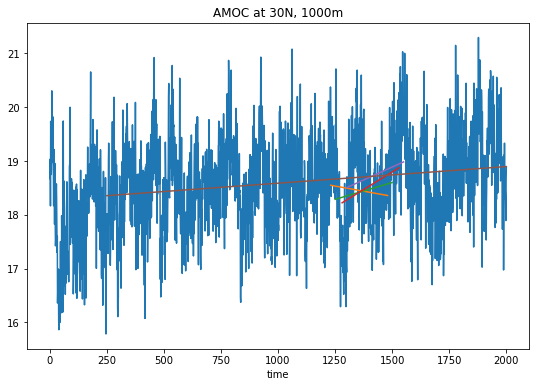

In [22]:
moc30_pi_ann.plot(size=6)
trend1231.plot()
trend1251.plot()
trend1281.plot()
trend1301.plot()
trend.plot()
plt.title("AMOC at 30N, 1000m");
#plt.draw()

In [23]:
trend.sel(time=slice(1231,1480)).time

<xarray.DataArray 'time' (time: 250)>
array([1231, 1232, 1233, ..., 1478, 1479, 1480])
Coordinates:
  * time     (time) int64 1231 1232 1233 1234 1235 ... 1476 1477 1478 1479 1480

In [25]:
moc_pi = ds0.MOC.sel(moc_z=100000.,method='nearest').sum('moc_comp')
moc_pi_ann = moc_pi.groupby('time.year').mean().rename({'year':'time'})
pitrend = fit_poly(moc_pi_ann.sel(time=slice(251,2000)),'time',1)

In [26]:
pitrend

<xarray.DataArray (time: 1750, transport_reg: 2, lat_aux_grid: 395)>
dask.array<sum-aggregate, shape=(1750, 2, 395), dtype=float64, chunksize=(1750, 2, 395), chunktype=numpy.ndarray>
Coordinates:
  * time           (time) int64 251 252 253 254 255 ... 1996 1997 1998 1999 2000
  * transport_reg  (transport_reg) int64 0 1
  * lat_aux_grid   (lat_aux_grid) float64 -79.49 -78.95 -78.42 ... 89.47 90.0

In [86]:
plist = ['1231','1251','1281','1301']
int(plist[0])

1231

In [91]:
y0 = int(plist[0])
y1 = y0+250
test = pitrend.sel(time=slice(y0,y1))
test['time'] = test['time'] + (1850-y0)

In [92]:
test.time

<xarray.DataArray 'time' (time: 251)>
array([1850, 1851, 1852, ..., 2098, 2099, 2100])
Coordinates:
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100

In [29]:
# Compute Ensemble Variance Decomposition:
plist = ['1231','1251','1281','1301']
varlist = []
meanlist = []
iyear = ds.inityear.data
for p in plist:
    y0 = int(p)
    y1 = y0+249
    trend = pitrend.sel(time=slice(y0,y1))
    trend['time'] = trend['time'] + (1850-y0)
    memind = np.nonzero(iyear==p)
    da_oneinit = ds.MOC.isel(member_id=memind[0])
    da_oneinit = da_oneinit - trend
    var = da_oneinit.var('member_id')
    mean = da_oneinit.mean('member_id')
    varlist.append(var)
    meanlist.append(mean)
sig2_atm = xr.concat(varlist,dim='p').mean('p')
sig2_ocn = xr.concat(meanlist,dim='p').var('p')
sig2_ocn_p = xr.concat(meanlist,dim=xr.DataArray(plist,dims='p',name='p'))
sig2_ocn_p = (sig2_ocn_p - sig2_ocn_p.mean('p'))**2

# Compute Chi
chi_atm_dt = (sig2_atm/sig2_tot).rename("Chi")
chi_ocn_dt = (sig2_ocn/sig2_tot).rename("Chi")
chi_ocn_dt_p = (sig2_ocn_p/sig2_tot).rename("Chi")

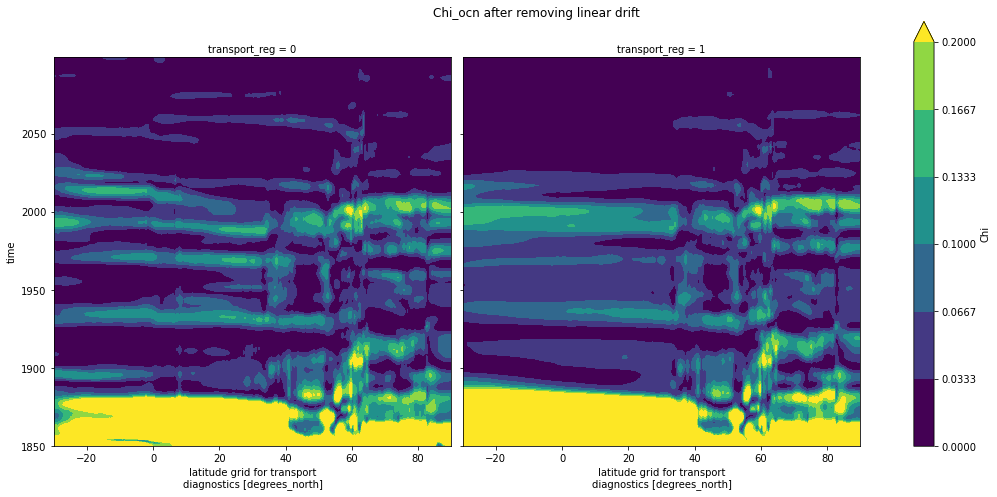

In [36]:
chi_ocn_dt.plot.contourf(col='transport_reg',vmin=0,vmax=0.2,size=7,xlim=[-30,90])
plt.suptitle("Chi_ocn after removing linear drift")
plt.subplots_adjust(top=0.88,right=0.8);

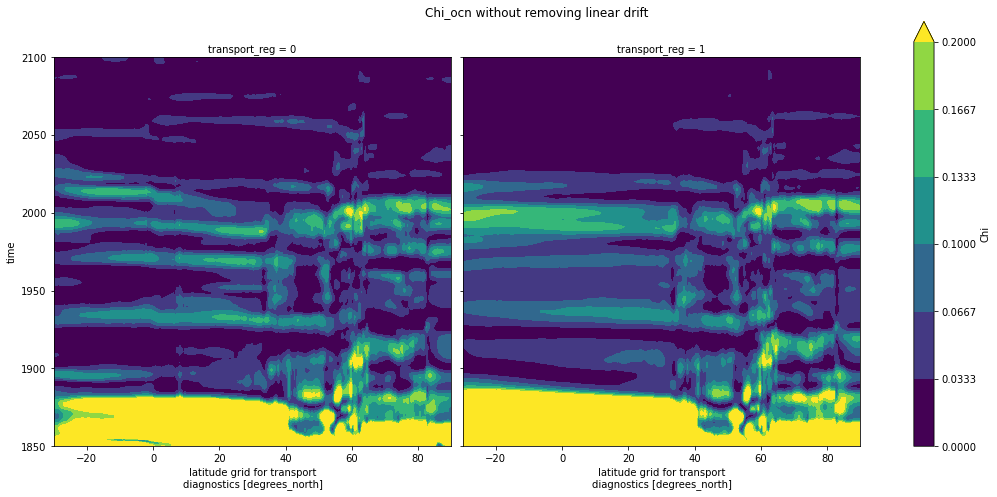

In [37]:
chi_ocn.plot.contourf(col='transport_reg',vmin=0,vmax=0.2,size=7,xlim=[-30,90])
plt.suptitle("Chi_ocn without removing linear drift")
plt.subplots_adjust(top=0.88,right=0.8);